In [1]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from amftrack.util.dbx import (upload
)
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,

)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from amftrack.transport.align_video_network import identify_nodes
logging.basicConfig(stream=sys.stdout, level=logging.debug)
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
mpl.rcParams["figure.dpi"] = 100
from amftrack.pipeline.functions.transport_processing.high_mag_videos.loading import load_video_dataset

from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
import networkx as nx
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import *

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [33]:
directory_targ = r"C:\Users\coren\Documents\temp_441/"


plate_id = "449_20230807"

update_plate_info(directory_targ, local=True,strong_constraint=False)
all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled2.p"] == True]
folders = folders.sort_values(by="folder")

folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
# i = indexes[plate_id_video]
# i = np.where(folders['folder'] == indexes[plate_id_video])[0][0]
# selection = folders[folders['folder'].isin(indexes.values())]
i = 0
exp.load(folders.iloc[i : i + 2], suffix="_labeled2")
# exp.load(selection, suffix="_labeled")

for t in range(exp.ts):
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)

# load_graphs(exp, directory_targ,indexes = [0])
    edges = get_all_edges(exp, t)

    weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
    nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph

analysed:   0%|          | 0/17 [00:00<?, ?it/s]

c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-13 02:06:00
2023-08-13 04:06:00


In [34]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.register_videos import *

In [53]:
trans

array([ 7.89830487, -2.83313306])

In [51]:
edges1 = get_all_edges(exp,0)
edges2 = get_all_edges(exp,1)
pixels1 = [pixel for edge in edges1 for pixel in edge.pixel_list(0)]
pixels2 = [pixel for edge in edges2 for pixel in edge.pixel_list(1)]
pixels1 = [node.pos(0) for node in get_all_nodes(exp,0) if node.degree(0)==3]
pixels2 = [node.pos(1) for node in get_all_nodes(exp,1) if node.degree(1)==3]
Y = np.array(pixels1)
X = np.array(pixels2)
R,trans = find_optimal_R_and_t(X,Y)


# R,trans = [[ 9.99999998e-01, -5.47823550e-05],
#         [ 5.47823550e-05,  9.99999998e-01]],[-26.55961022, -13.15116421]

edges1 = get_all_edges(exp,0)
edges2 = get_all_edges(exp,1)
pixels1 = [pixel for edge in edges1 for pixel in edge.pixel_list(0)]
pixels2 = [pixel for edge in edges2 for pixel in edge.pixel_list(1)]

pixels1 = (np.array(R)@np.array(pixels1).T).T+np.array(trans)
# pixels1 = np.array(pixels1)
pixels2 = np.array(pixels2)

Current parameters: [-3.50000000e+03  3.50000000e+03 -9.81747704e-02], Objective Function Value: 88146.71525580392
Current parameters: [-3.50000000e+03  3.50000000e+03 -9.81747704e-02], Objective Function Value: 88146.71525580392
Current parameters: [-3.50000000e+03  3.50000000e+03 -9.81747704e-02], Objective Function Value: 88146.71525580392
Current parameters: [-3.50000000e+03  3.50000000e+03 -9.81747704e-02], Objective Function Value: 88146.71525580392
Current parameters: [-1.11805556e+03 -2.75462963e+02 -6.22682572e-02], Objective Function Value: 79631.84112984981
Current parameters: [-2.17939815e+03  3.59182099e+02 -5.35567613e-02], Objective Function Value: 70780.84350052458
Current parameters: [-1.42457562e+03  2.25006430e+03 -5.47561702e-02], Objective Function Value: 57998.71454644436
Current parameters: [-6.11014660e+02 -5.83108282e+02 -3.62032091e-02], Objective Function Value: 54913.26370803881
Current parameters: [-6.11014660e+02 -5.83108282e+02 -3.62032091e-02], Objective

In [19]:
edges1 = get_all_edges(exp,0)
edges2 = get_all_edges(exp,1)
pixels1 = [pixel for edge in edges1 for pixel in edge.pixel_list(0)]
pixels2 = [pixel for edge in edges2 for pixel in edge.pixel_list(1)]
R2 = np.linalg.inv(R)
trans2 = -R2@trans
pixels2 = (np.array(R2)@np.array(pixels2).T).T+np.array(trans2)
pixels1 = np.array(pixels1)
# pixels2 = np.array(pixels2)

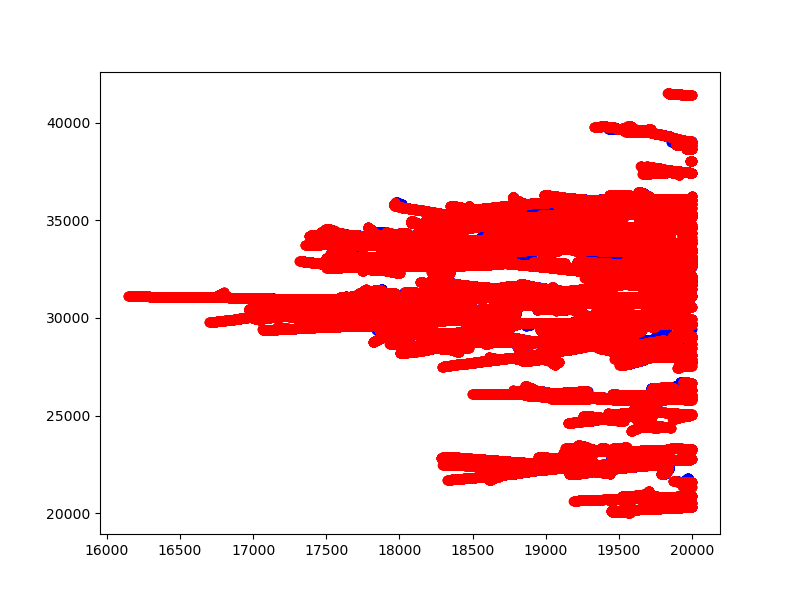

In [52]:

pixel_select1 = pixels1[np.where(pixels1[:,0]<=20000)]
pixel_select2 = pixels2[np.where(pixels2[:,0]<=20000)]

fig,ax = plt.subplots(figsize=(8, 6))

# Plot each array of coordinates in a different color
ax.scatter(pixel_select1[:, 0], pixel_select1[:, 1], color='blue', label='Array 1')  # Blue color for the first array
ax.scatter(pixel_select2[:, 0], pixel_select2[:, 1], color='red', label='Array 2')  # Red color for the second array


In [21]:
def transform_pixel_list(pixel_list,R,trans):
    return([R@np.array(pixel)+trans for pixel in pixel_list])

In [22]:
t = 1
edges = get_all_edges(exp, t)

new_pixel_list = {(edge.begin.label, edge.end.label): transform_pixel_list(edge.pixel_list(t),R2,trans2) for edge in edges}

nx.set_edge_attributes(exp.nx_graph[t], new_pixel_list, "pixel_list")

In [23]:
pos = exp.positions[t]
pos = {node: R2@pos[node]+trans2 for node in pos.keys()}

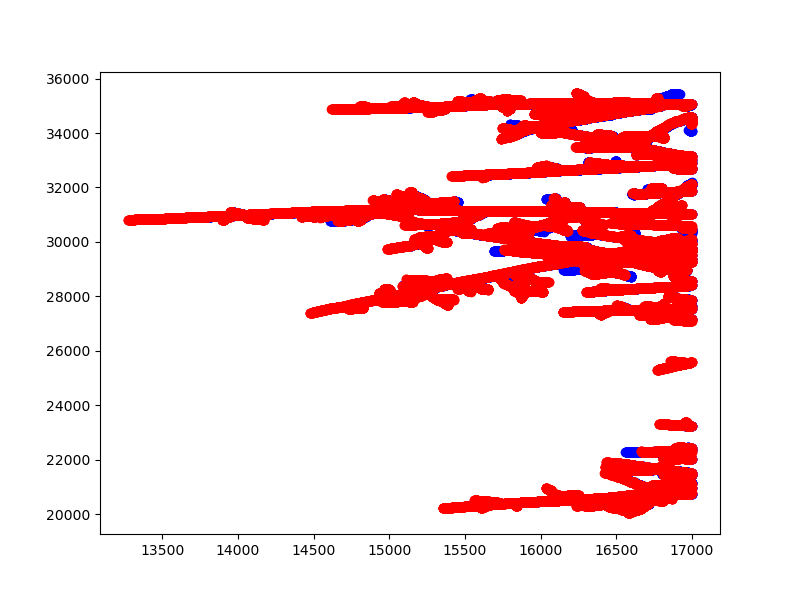

In [24]:
edges1 = get_all_edges(exp,0)
edges2 = get_all_edges(exp,1)
pixels1 = [pixel for edge in edges1 for pixel in edge.pixel_list(0)]
pixels2 = [pixel for edge in edges2 for pixel in edge.pixel_list(1)]
pixels1 = np.array(pixels1)
pixels2 = np.array(pixels2)
pixel_select1 = pixels1[np.where(pixels1[:,0]<=17000)]
pixel_select2 = pixels2[np.where(pixels2[:,0]<=17000)]

fig,ax = plt.subplots(figsize=(8, 6))

# Plot each array of coordinates in a different color
ax.scatter(pixel_select1[:, 0], pixel_select1[:, 1], color='blue', label='Array 1')  # Blue color for the first array
ax.scatter(pixel_select2[:, 0], pixel_select2[:, 1], color='red', label='Array 2')  # Red color for the second array


In [25]:
import pickle
t = 1
directory_name = exp.folders['folder'].iloc[t]
path_snap = directory_targ + directory_name
path_save = path_snap + "/Analysis/nx_graph_pruned_labeled2.p"
pickle.dump((exp.nx_graph[t], pos), open(path_save, "wb"))
